In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys; sys.path.append("../")

from utils import load_json

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

#### Plot `ResNet18` results

In [19]:
def plot_corruption_results(model_name, model_results, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.axhline(y=model_results["clean"], label=f"Clean [ {model_results['clean']:.4f} ]")

    severity_values = [1, 2, 3, 4, 5]
    corruption_wise_results = defaultdict(list)
    for key, top1 in model_results.items():
        if key != "clean":
            corruption, severity = key.split("_transform_")
            corruption_wise_results[corruption].append(top1)

    for corruption, values in corruption_wise_results.items():
        ax.plot(severity_values, values, "--o", label=corruption.replace("_", " ").capitalize())

    ax.set_title(f"{model_name.upper().replace('_', '-')}: Top-1 accuracy vs Severity of corruption", fontsize=20)
    ax.grid()
    ax.set_xlabel("Severity of corruption", fontsize=12)
    ax.set_ylabel("Top-1 accuracy", fontsize=12)
    ax.legend(fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_ylim(0.2, 1.0)

    plt.savefig(f"../results/{model_name}_top1_vs_severity.png", bbox_inches="tight")
    plt.show()

In [20]:
path = "../results/resnet18_results.json"

In [21]:
results = load_json(path)

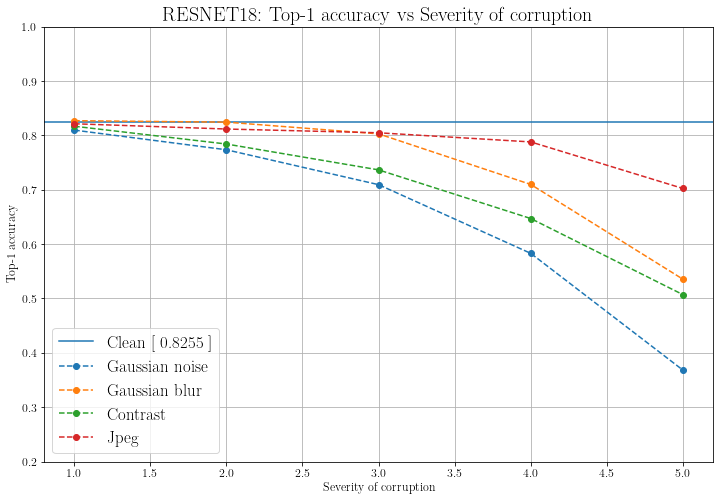

In [22]:
plot_corruption_results("resnet18", results)

### Computing `CE` and `RCE` for various models

In [44]:
def get_corruption_wise_results(results):
    corruption_wise_results = defaultdict(list)
    for key, top1 in results.items():
        if key != "clean":
            corruption, severity = key.split("_transform_")
            corruption_wise_results[corruption].append(top1)
    return corruption_wise_results


def compute_corruption_error(model_name, model_results, resnet18_results):
    mce = get_corruption_wise_results(model_results)
    mce = {k: 1 - np.array(v) for k, v in mce.items()}
    rce = get_corruption_wise_results(resnet18_results)
    rce = {k: 1 - np.array(v) for k, v in rce.items()}
    
    mce = {k:np.sum(v) for k, v in mce.items()}
    rce = {k:np.sum(v) for k, v in rce.items()}
    
    return {k: mce[k]/rce[k] for k in mce}


def compute_relative_corruption_error(model_name, model_results, resnet18_results):
    mce = get_corruption_wise_results(model_results)
    mce = {k: 1 - np.array(v) for k, v in mce.items()}
    rce = get_corruption_wise_results(resnet18_results)
    rce = {k: 1 - np.array(v) for k, v in rce.items()}
    
    mce = {k:np.sum(v) for k, v in mce.items()}
    rce = {k:np.sum(v) for k, v in rce.items()}
    
    return {
        k: (mce[k] - model_results["clean"])/(rce[k] - resnet18_results["clean"]) for k in mce
    }

In [45]:
compute_corruption_error("resnet18", results, results)

{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}

In [46]:
compute_relative_corruption_error("resnet18", results, results)

{'gaussian_noise': 1.0, 'gaussian_blur': 1.0, 'contrast': 1.0, 'jpeg': 1.0}

### Show results for all models

In [47]:
import pandas as pd

resnet34


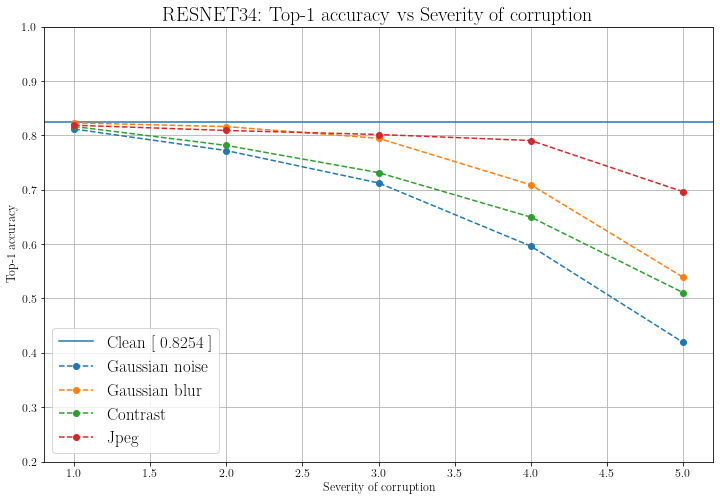

CE
RCE
vgg11


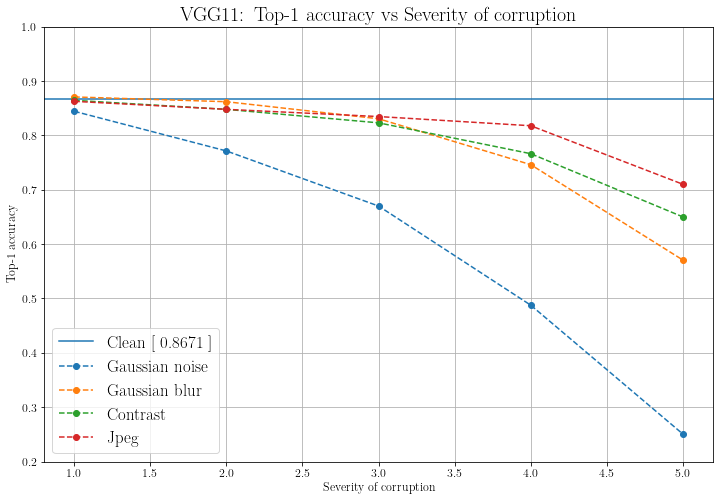

CE
RCE
vgg11_bn


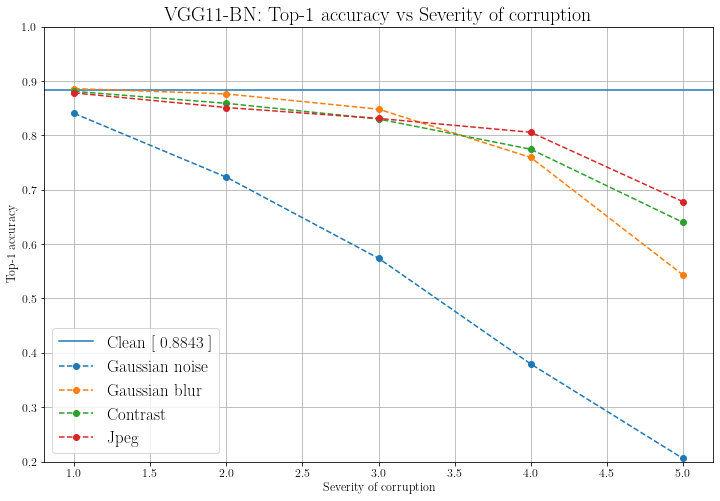

CE
RCE
densenet121


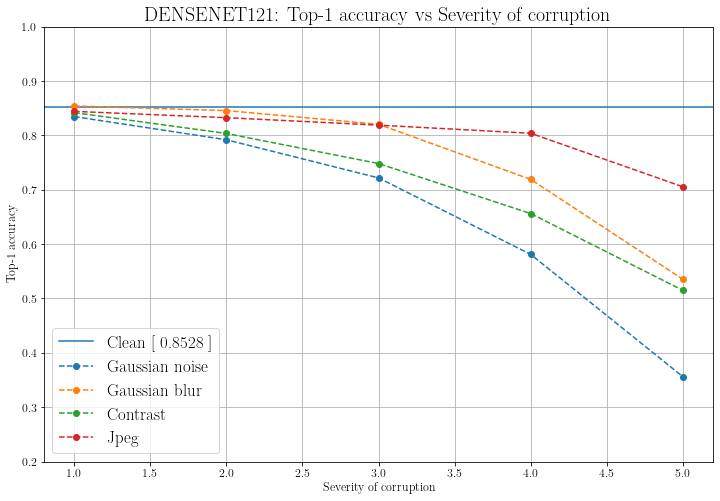

CE
RCE


In [48]:
model_names = ["resnet34", "vgg11", "vgg11_bn", "densenet121"]
corruptions = ["gaussian_noise", "gaussian_blur", "contrast", "jpeg"]
df_ce = pd.DataFrame(None, columns=corruptions, index=model_names)
df_rce = pd.DataFrame(None, columns=corruptions, index=model_names)

for model_name in model_names:
    print(model_name)
    path = f"../results/{model_name}_results.json"
    model_results = load_json(path)
    plot_corruption_results(model_name, model_results)
    print("CE")
    ce = compute_corruption_error(model_name, model_results, results)
    df_ce.loc[model_name] = ce
    print("RCE")
    rce = compute_relative_corruption_error(model_name, model_results, results)
    df_rce.loc[model_name] = rce

In [51]:
from torchsummary import summary

In [49]:
df_ce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.961146,1.013154,1.001049,1.01098
vgg11,1.125232,0.861086,0.69488,0.86492
vgg11_bn,1.296807,0.835538,0.673179,0.89177
densenet121,0.976294,0.942442,0.951616,0.928492


In [133]:
def plot_multiple_categorical_histogram(
        x,
        lists_of_counts,
        labels,
        xlabels,
        width=0.6,
        figsize=(6, 5),
        title="Categorical distribution",
        xlabel="Classes",
        ylabel="Counts",
        filname="../results/sample.png",
    ):
    """Plots bar-plot."""

    # assert len(lists_of_values) == len(labels)
    num_distributions = len(labels)
    width_per_dist = width / num_distributions
    starting_points = np.linspace(-width_per_dist, width_per_dist, num_distributions)
    offset = width_per_dist / num_distributions
    center_points = [x + ((x < 0) * offset) + (-1 * (x > 0) * offset) for x in starting_points]
    center_points = [[-0.875, -0.125, 0.125, 0.875] for _ in range(num_distributions)]
    center_points = np.array([-0.375, -0.125, 0.125, 0.375])

    fig, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)

    for i, values in enumerate(lists_of_counts):
        ax.bar(
            x=x - center_points[i],
            height=lists_of_counts[i],
            label=labels[i].replace("_", "-"),
            width=width_per_dist,
            align="center",
        )

    ax.grid()
    ax.set_title(title, fontsize=18)
    _xlabels = ["" for i in range(x[-1] + 1)]
    for i, z in enumerate(x):
        _xlabels[z] = xlabels[i].replace("_", "-")
    ax.set_xticklabels(_xlabels, fontsize=13)

    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.legend(fontsize=13)
    
    plt.savefig(filname, bbox_inches="tight")

    plt.show()

/var/folders/nw/93_by3716yn881ckngw_vmp40000gn/T/ipykernel_17218/1641375832.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(_xlabels, fontsize=13)


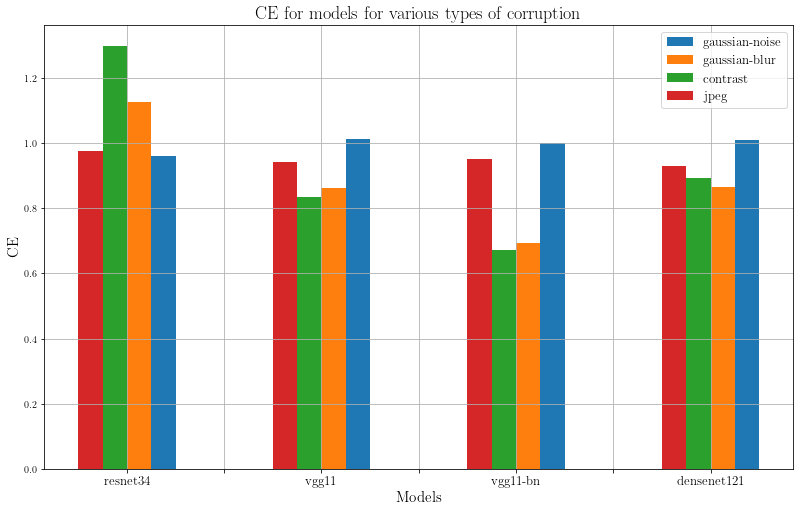

In [136]:
plot_multiple_categorical_histogram(
    [1, 3, 5, 7],
    [list(df_ce.loc[x]) for x in df_ce.index],
    labels=list(df_ce.columns),
    xlabels=list(df_ce.index),
    title="CE for models for various types of corruption",
    xlabel="Models",
    ylabel="CE",
    width=1.0,
    figsize=(11, 7),
    filname="../results/ce_error_across_models.png"
)

/var/folders/nw/93_by3716yn881ckngw_vmp40000gn/T/ipykernel_17218/1641375832.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(_xlabels, fontsize=13)


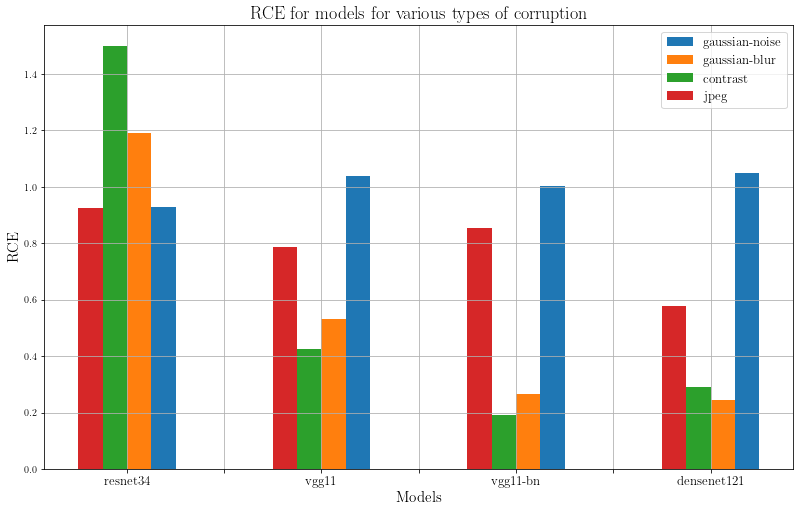

In [137]:
plot_multiple_categorical_histogram(
    [1, 3, 5, 7],
    [list(df_rce.loc[x]) for x in df_rce.index],
    labels=list(df_rce.columns),
    xlabels=list(df_rce.index),
    title="RCE for models for various types of corruption",
    xlabel="Models",
    ylabel="RCE",
    width=1.0,
    figsize=(11, 7),
    filname="../results/rce_error_across_models.png"
)

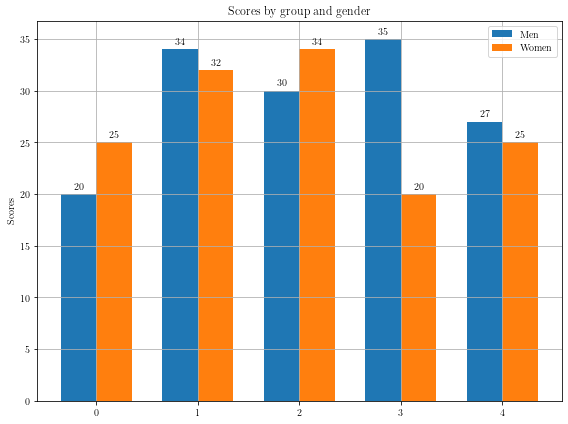

In [56]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
# ax.set_xticks(labels)
ax.legend()
ax.grid()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [ ]:
xvalues = list(df_ce.index)

In [50]:
df_rce

,gaussian_noise,gaussian_blur,contrast,jpeg
resnet34,0.926796,1.036212,1.002462,1.048174
vgg11,1.191564,0.532154,0.265132,0.243276
vgg11_bn,1.496813,0.426015,0.192007,0.290245
densenet121,0.925839,0.784807,0.853026,0.57768
